In [1]:
!pip install transformers datasets evaluate


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install librosa

     -------------------------------------- 253.7/253.7 kB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 922.9 kB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 926.6 kB/s eta 0:00:00
     -------------------------------------- 62.7/62.7 kB 845.9 kB/s eta 0:00:00
     -------------------------------------- 184.6/184.6 kB 1.0 MB/s eta 0:00:00
     -------------------------------------- 222.8/222.8 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 28.1/28.1 MB 1.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install soundfile


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (manager-core).
Your token has been saved to C:\Users\RanggaSaputra\.cache\huggingface\token
Login successful


In [11]:
import pandas as pd
import IPython.display as ipd

from scipy import signal
from scipy.io import wavfile

from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.fft import fft, fftfreq


import librosa
import librosa.display

import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

from datasets import load_dataset, Audio
from transformers import AutoProcessor

## Sinyal

In [12]:
def eda_plots(sample_data):

    data, samplerate = librosa.load(sample_data['path'], sr = sample_data['audio']['sampling_rate'])
    sample_audio = sample_data["audio"]

    # 1. plot the waveform

    fig, axs = plt.subplots(4,1,figsize=(18,15), gridspec_kw={'height_ratios': [1, 1, 1, 1.75]})
    axs[0].set_title('Waveform')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_xlabel('Time (s)')
    librosa.display.waveshow(data, sr=samplerate, ax=axs[0])
    axs[0].set_xlim((0, len(data)/samplerate))


    # 2. plot the Spectogram

    # # IF using mel scale
    # spectogram = librosa.feature.melspectrogram(y=data, sr=samplerate)        # Compute the spectrogram using Mel scale
    # spectogram_log = librosa.power_to_db(spectogram,  ref=np.max)                 # Convert power spectrogram to dB scale
    # librosa.display.specshow(xdb, sr=samplerate, x_axis='time', y_axis='mel', ax=axs[1], cmap= 'magma')


    # # IF using Hertz
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))

    librosa.display.specshow(xdb, sr=samplerate, x_axis='time', y_axis='hz', ax=axs[1], cmap= 'viridis')
    axs[1].set_title('Spectrogram')
    axs[1].set_ylabel('Frequency (Hz)')
    axs[1].set_xlabel('Time (s)')
    # plt.colorbar(spect, cax= axs[1], label='Intensity (dB)')
    axs[1].set_xlim((0, len(data)/samplerate))


    # 3. plot MFCC

    mfccs = librosa.feature.mfcc(y=data, sr=samplerate, n_mfcc=13)
    librosa.display.specshow(mfccs, x_axis='time', sr=samplerate, ax=axs[2], cmap= 'viridis')

    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('MFCC Coefficients')
    axs[2].set_title('MFCCs')


    # 4. plot the FFT

    N = len(data)
    x = np.linspace(0, N/samplerate, N, endpoint=False)
    xf = fftfreq(N, 1/samplerate)[:N//2]
    yf = fft(data)
    axs[3].plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    axs[3].set_title('Fast Fourier Transform (FFT)')
    axs[3].set_ylabel('Magnitude')
    axs[3].set_xlabel('Frequency (Hz)')
    axs[3].set_xlim((0, max(xf)+5))

    plt.tight_layout()
    plt.show()


    plt.tight_layout()
    plt.show()

    print(f"text script audio: {sample_data['transcription']}")
    print(f'intent class: {minds_en["train"].features["intent_class"].names[sample_data["intent_class"]]}')

In [8]:
# load all data en-US
minds_en = load_dataset("PolyAI/minds14", name="en-US")
minds_en

Generating train split: 0 examples [00:00, ? examples/s]

Dataset minds14 downloaded and prepared to C:/Users/RanggaSaputra/.cache/huggingface/datasets/PolyAI___minds14/en-US/1.0.0/65c7e0f3be79e18a6ffaf879a083daf706312d421ac90d25718459cbf3c42696. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 563
    })
})

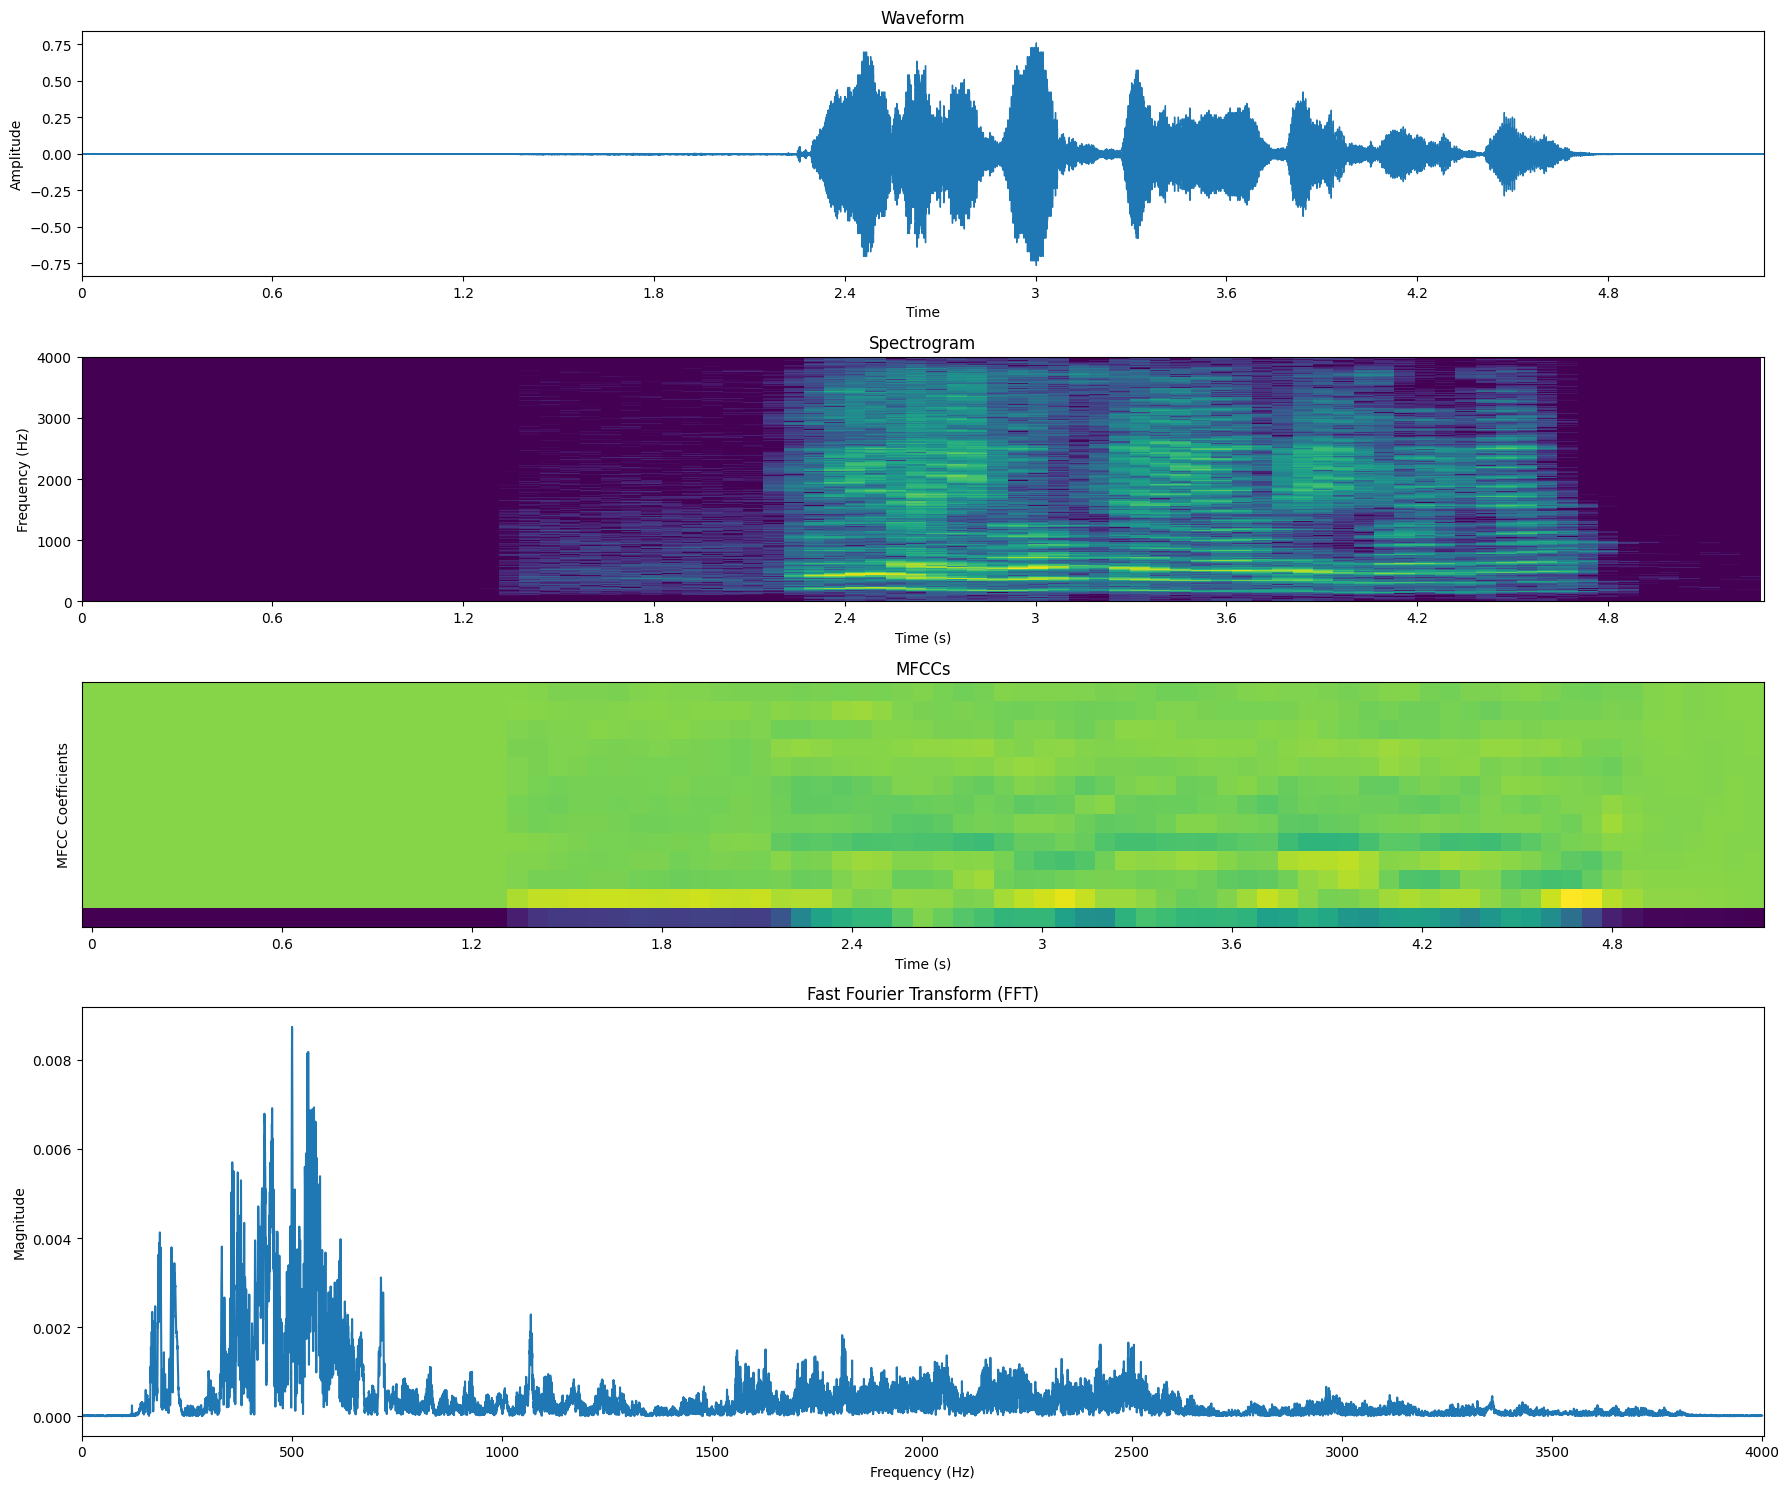

<Figure size 640x480 with 0 Axes>

text script audio: I need help setting up a joint account
intent class: joint_account


In [14]:
### Sample Data 1

sample_data = minds_en["train"][10]
eda_plots(sample_data)
ipd.Audio(sample_data["audio"]['path'])

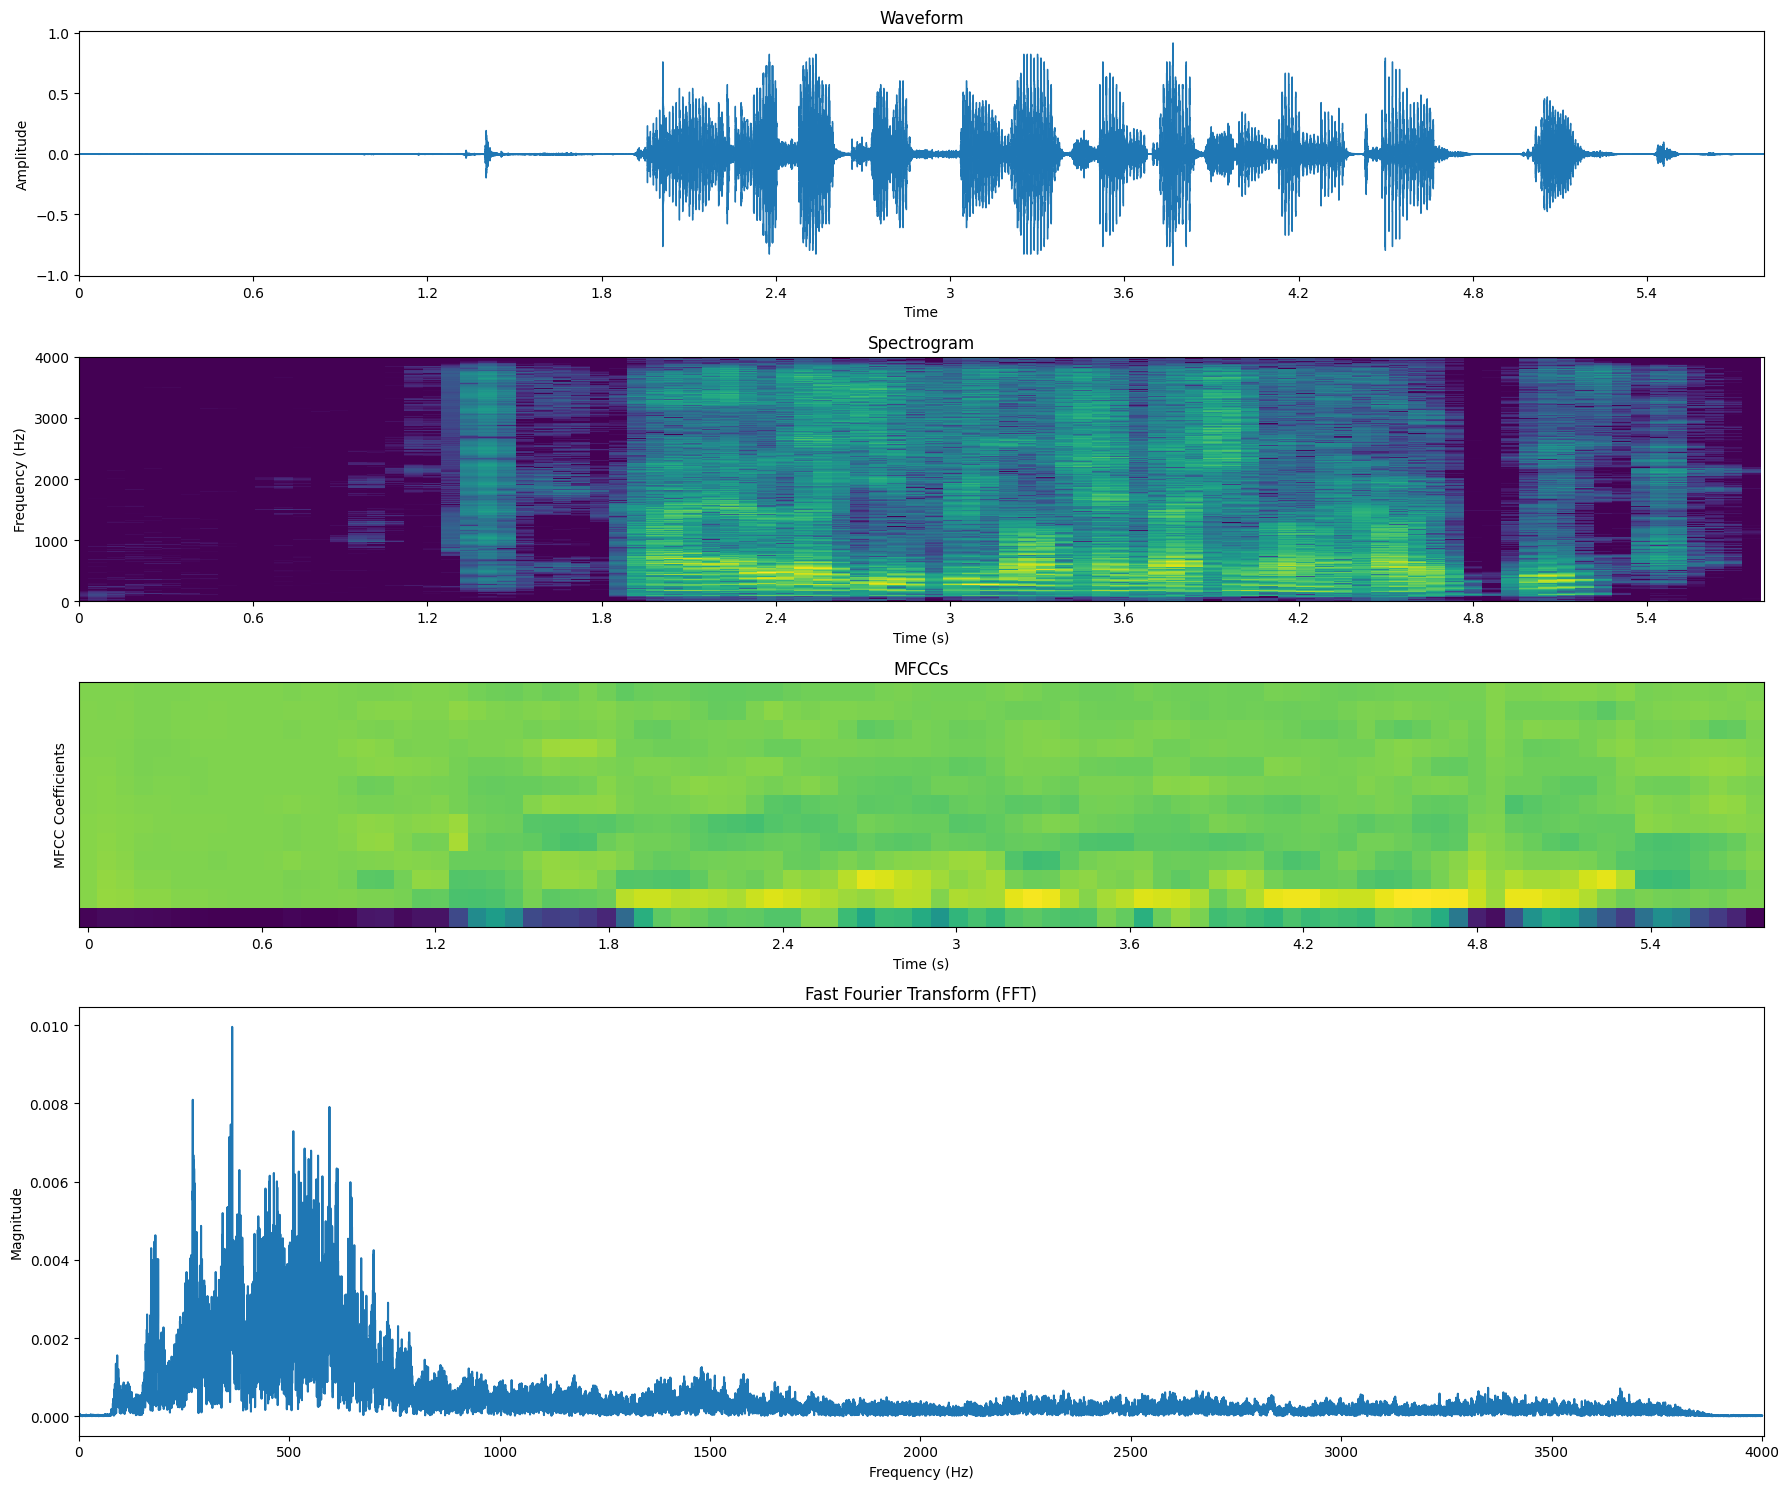

<Figure size 640x480 with 0 Axes>

text script audio: I would like you to freeze all transactions on my card please
intent class: freeze


In [15]:
### Sample Data 2

sample_data = minds_en["train"][150]
eda_plots(sample_data)
ipd.Audio(sample_data["audio"]['path'])

## Persebaran class

In [16]:
# convert to format pandas DataFrame
minds_en.set_format(type="pandas")
df = minds_en["train"][:]

intent_names = minds_en["train"].features["intent_class"].names

def mapping_intent(i):
    return intent_names[i]

df["intent_name"] = df["intent_class"].map(mapping_intent)
df["len_transcription"] = df["transcription"].map(len)

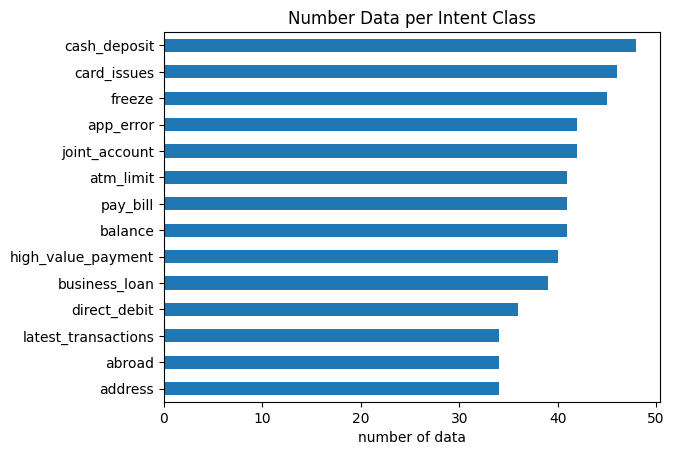

In [17]:
# number data each intent class
df.intent_name.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.title("Number Data per Intent Class")
plt.xlabel("number of data")
plt.ylabel("")
plt.show()
